# Comparación de algoritmo de predicción de performance para arquitecturas neuronales de clasificación usando comparación bayesiana

En este trabajo utilizamos la librería baycomp, la cual permite comparar listas de rendimiento en uno o varios conjuntos de datos y nos proporciona la superioridad del conjunto A o del conjunto B (clasificadores a los que pertenece la lista de rendimiento) en forma de probabilidad: p_left, p_rope, p_right.

Es necesario crear una lista de rendimiento, lo que logramos obteniendo el coeficiente de correlación de Spearman cada 10 individuos ordenados. Esto nos permite generar una nueva lista de correlaciones que refleja el rendimiento de la clasificación. Dado que la escala 0-1 utiliza un rope de 0.01, nuestra escala, que tiene un rango de -1 a 1, emplea un rope de 0.005 (la mitad de 0.01). Para cada comparación, se realizan 10 ejecuciones de validación cruzada.

In [414]:
import numpy as np
import baycomp
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import pearsonr, spearmanr

In [415]:
# Variables globales
global_results = pd.DataFrame(columns=["Dataset", "Algorithm A", "Algorithm B", "size_dataset", "P(A>B)", "P(A=B)", "P(B>A)"])

Cargamos los clasificadores a comparar

In [416]:
classifier_A_name = "./results/results_gradiente_cosine_estimator_cifar10_10000.csv"
classifier_B_name = "./results/results_synflow_ones_estimator_cifar10_10000.csv"

classifier_A = pd.read_csv(classifier_A_name)
classifier_B = pd.read_csv(classifier_B_name)

## Preparando lista de accuracy

No podemos pasar directamente el score predicho al algoritmo de comparación bayesiana, ya que debemos usar una lista de rendimiento (accuracy), que nos indica qué tan bien ha predicho el modelo una arquitectura neuronal. El score es un indicador del potencial de la red, pero lo que necesitamos es un indicador de cuán acertado es ese score en comparación con su accuracy. En el caso de Gradient Cosine, esto es más sencillo porque los scores tienen un intervalo de 0 a 1. Sin embargo, en SynFlow es más complicado, ya que los valores pueden variar desde 0 hasta el tamaño de la red o incluso más, lo que dificulta proporcionar medidas precisas y puede introducir sesgos.

En este documento, proponemos utilizar lotes de datos, donde cada lote tiene un coeficiente de correlación de Spearman que indica la linealidad en la distribución de los datos. Cuanto más lineal (más cercano a 1) sea el valor, mejor será el desempeño de la predicción (score). Así, creamos un arreglo donde cada elemento es un coeficiente de correlación lineal, y el arreglo completo constituye una lista de rendimiento de las predicciones. Aunque al utilizar lotes podríamos estar perdiendo algo de información del conjunto completo, es una buena aproximación para obtener un indicador del rendimiento de las predicciones.

Para esta prueba, se recomienda utilizar la misma muestra de arquitecturas para ambos clasificadores

In [417]:
def show_pearson_and_spearman_correlations(classifier_A, classifier_B):
    # Obtenemos el coeficiente de correlación de Pearson y Spearman para el score de cada clasiicador
    pearson_corr = pearsonr(classifier_A['Score'], classifier_A['Accuracy'])
    spearman_corr = spearmanr(classifier_A['Score'], classifier_A['Accuracy'])
    print(f"Correlación de Pearson para classifier_A_name: {pearson_corr[0]}")
    print(f"Correlación de Spearman para classifier_A_name: {spearman_corr[0]}", end="\n\n")

    pearson_corr = pearsonr(classifier_B['Score'], classifier_B['Accuracy'])
    spearman_corr = spearmanr(classifier_B['Score'], classifier_B['Accuracy'])
    print(f"Correlación de Pearson para classifier_B_name: {pearson_corr[0]}")
    print(f"Correlación de Spearman para classifier_B_name: {spearman_corr[0]}")

show_pearson_and_spearman_correlations(classifier_A, classifier_B)

Correlación de Pearson para classifier_A_name: 0.5315799981546845
Correlación de Spearman para classifier_A_name: 0.5259138105962688

Correlación de Pearson para classifier_B_name: 0.7107966842921501
Correlación de Spearman para classifier_B_name: 0.5468799844835498


In [418]:
def get_correlations_in_batches(classifier_A, classifier_B, batch_size = 10, shuffle = False):
  """ 
    Obtiene el coeficiente de correlación de Spearman para el score de cada clasificador cada batch_size.
    Args:
      classifier_A (DataFrame): Resultados del clasificador A (Score y Accuracy).
      classifier_B (DataFrame): Resultados del clasificador B (Score y Accuracy).
      batch_size (int): Tamaño del batch.
      shuffle (bool): Si se desea mezclar los datos.
  """
  spearman_corr_A = []
  spearman_corr_B = []

  # si se desea se mezclan los datos
  if shuffle:
    classifier_A = classifier_A.sample(frac=1).reset_index(drop=True)
    classifier_B = classifier_B.sample(frac=1).reset_index(drop=True)

  # Obtenemos el coeficiente de Spearman por cada batch del total de datos
  for i in range(0, len(classifier_A['Score']), batch_size):
      # Batch A
      batch_A_score = classifier_A['Score'][i:i+batch_size]
      batch_A_accuracy = classifier_A['Accuracy'][i:i+batch_size]
      # Batch B
      batch_B_score = classifier_B['Score'][i:i+batch_size]
      batch_B_accuracy = classifier_B['Accuracy'][i:i+batch_size]

      spearman_corr_A.append(spearmanr(batch_A_score, batch_A_accuracy)[0])
      spearman_corr_B.append(spearmanr(batch_B_score, batch_B_accuracy)[0])

  spearman_corr_A = np.array(spearman_corr_A)
  spearman_corr_B = np.array(spearman_corr_B)

  return spearman_corr_A, spearman_corr_B

In [419]:
# get correlations in batches
spearman_corr_A, spearman_corr_B = get_correlations_in_batches(classifier_A, classifier_B, shuffle=True)

probabilities = baycomp.two_on_single(spearman_corr_A, spearman_corr_B, rope=0.005, runs=10)
print(f"Probabilidad de que el clasificador A sea mejor que el clasificador B: {probabilities[0]}")
print(f"Probabilidad de que el clasificador A sea igual al clasificador B: {probabilities[1]}")
print(f"Probabilidad de que el clasificador B sea mejor que el clasificador A: {probabilities[2]}")

Probabilidad de que el clasificador A sea mejor que el clasificador B: 0.2150595246084398
Probabilidad de que el clasificador A sea igual al clasificador B: 0.08006787032662943
Probabilidad de que el clasificador B sea mejor que el clasificador A: 0.7048726050649308


## Pruebas en CIFAR10

Ahora que ya entendimos el método, comparamos los diferentes clasificadores (gradient scorer, gradient cosine and synflow).

### Gradient scorer vs Synflow

In [420]:
# Cargamos los clasificadores synflow y gradient scorer para 15 mil redes en cifar10
classifier_A_name = "./results/results_gradient_scorer_cifar10_15000.csv"
classifier_B_name = "./results/results_synflow_ones_estimator_cifar10_15000.csv"

classifier_A = pd.read_csv(classifier_A_name)
classifier_B = pd.read_csv(classifier_B_name)

In [421]:
# Mostramos sus correlaciones
show_pearson_and_spearman_correlations(classifier_A, classifier_B)

Correlación de Pearson para classifier_A_name: 0.8165427606781992
Correlación de Spearman para classifier_A_name: 0.5811682525063159

Correlación de Pearson para classifier_B_name: 0.7090887683324223
Correlación de Spearman para classifier_B_name: 0.5474419080419214


Probabilidad de que el clasificador A sea mejor que el clasificador B: 0.8755156310848085
Probabilidad de que el clasificador A sea igual al clasificador B: 0.06313158037538691
Probabilidad de que el clasificador B sea mejor que el clasificador A: 0.06135278853980464


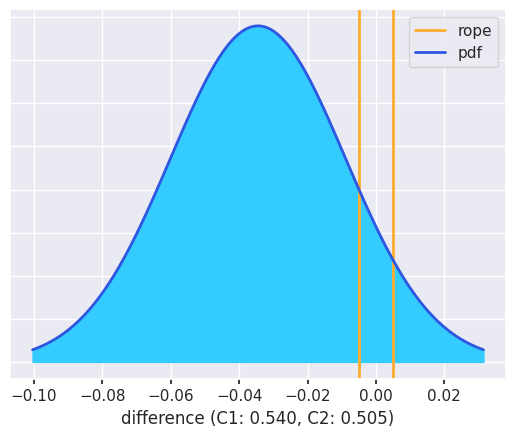

In [422]:
# Obtenemos las correlaciones en batches
spearman_corr_A, spearman_corr_B = get_correlations_in_batches(classifier_A, classifier_B)

# Calculamos las probabilidades usando baycomp
probabilities, fig = baycomp.two_on_single(spearman_corr_A, spearman_corr_B, rope=0.005, runs=10, plot=True)
print(f"Probabilidad de que el clasificador A sea mejor que el clasificador B: {probabilities[0]}")
print(f"Probabilidad de que el clasificador A sea igual al clasificador B: {probabilities[1]}")
print(f"Probabilidad de que el clasificador B sea mejor que el clasificador A: {probabilities[2]}")

plt.show()

In [423]:
# Agregar resultados a global_results
global_results = pd.concat([
    global_results,
    pd.DataFrame([["cifar10", "gradient_scorer", "synflow_ones_estimator", 15000, probabilities[0], probabilities[1], probabilities[2]]] , columns=global_results.columns)
])

### Gradient scorer vs Gradient cosine

In [424]:
# Cargamos los clasificadores gradient scorer y gradient cosine para 15 mil redes en cifar10
classifier_A_name = "./results/results_gradient_scorer_cifar10_15000.csv"
classifier_B_name = "./results/results_gradiente_cosine_estimator_cifar10_15000.csv"

classifier_A = pd.read_csv(classifier_A_name)
classifier_B = pd.read_csv(classifier_B_name)

In [425]:
# Mostramos sus correlaciones
show_pearson_and_spearman_correlations(classifier_A, classifier_B)

Correlación de Pearson para classifier_A_name: 0.8165427606781992
Correlación de Spearman para classifier_A_name: 0.5811682525063159

Correlación de Pearson para classifier_B_name: 0.5447679871093214
Correlación de Spearman para classifier_B_name: 0.5487261080426726


Probabilidad de que el clasificador A sea mejor que el clasificador B: 0.88031411466838
Probabilidad de que el clasificador A sea igual al clasificador B: 0.059355827224762514
Probabilidad de que el clasificador B sea mejor que el clasificador A: 0.06033005810685743


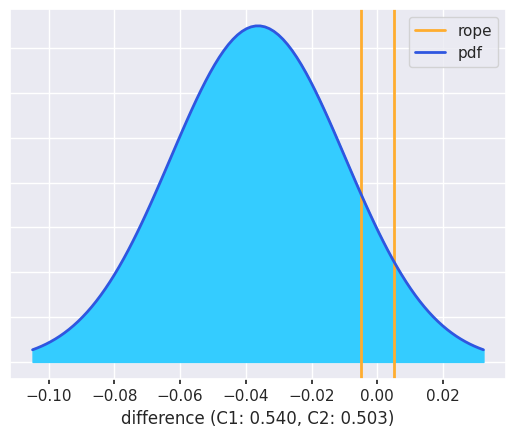

In [426]:
# Obtenemos las correlaciones en batches
spearman_corr_A, spearman_corr_B = get_correlations_in_batches(classifier_A, classifier_B)

# Calculamos las probabilidades usando baycomp
probabilities, fig = baycomp.two_on_single(spearman_corr_A, spearman_corr_B, rope=0.005, runs=10, plot=True)
print(f"Probabilidad de que el clasificador A sea mejor que el clasificador B: {probabilities[0]}")
print(f"Probabilidad de que el clasificador A sea igual al clasificador B: {probabilities[1]}")
print(f"Probabilidad de que el clasificador B sea mejor que el clasificador A: {probabilities[2]}")

plt.show()

In [427]:
# Agregar resultados a global_results
global_results = pd.concat([
    global_results,
    pd.DataFrame([["cifar10", "gradient_scorer", "gradient_cosine_estimator", 15000, probabilities[0], probabilities[1], probabilities[2]]] , columns=global_results.columns)
])

### Synflow vs gradient cosine

In [428]:
# Cargamos los clasificadores synflow y gradient cosine para 15 mil redes en cifar10
classifier_A_name = "./results/results_synflow_ones_estimator_cifar10_15000.csv"
classifier_B_name = "./results/results_gradiente_cosine_estimator_cifar10_15000.csv"

classifier_A = pd.read_csv(classifier_A_name)
classifier_B = pd.read_csv(classifier_B_name)

In [429]:
# Mostramos sus correlaciones
show_pearson_and_spearman_correlations(classifier_A, classifier_B)

Correlación de Pearson para classifier_A_name: 0.7090887683324223
Correlación de Spearman para classifier_A_name: 0.5474419080419214

Correlación de Pearson para classifier_B_name: 0.5447679871093214
Correlación de Spearman para classifier_B_name: 0.5487261080426726


Probabilidad de que el clasificador A sea mejor que el clasificador B: 0.39857732776046995
Probabilidad de que el clasificador A sea igual al clasificador B: 0.311115460188653
Probabilidad de que el clasificador B sea mejor que el clasificador A: 0.29030721205087706


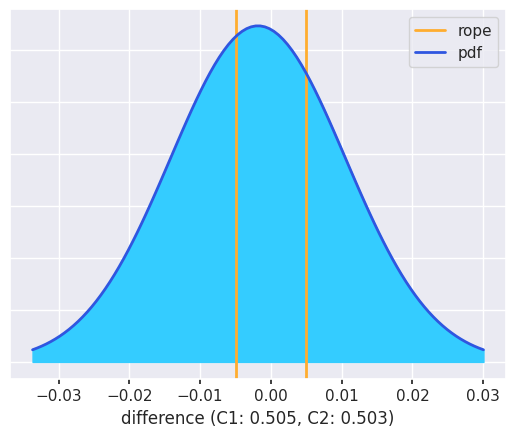

In [430]:
# Obtenemos las correlaciones en batches
spearman_corr_A, spearman_corr_B = get_correlations_in_batches(classifier_A, classifier_B)

# Calculamos las probabilidades usando baycomp
probabilities, fig = baycomp.two_on_single(spearman_corr_A, spearman_corr_B, rope=0.005, runs=10, plot=True)
print(f"Probabilidad de que el clasificador A sea mejor que el clasificador B: {probabilities[0]}")
print(f"Probabilidad de que el clasificador A sea igual al clasificador B: {probabilities[1]}")
print(f"Probabilidad de que el clasificador B sea mejor que el clasificador A: {probabilities[2]}")

plt.show()

In [431]:
# Agregar resultados a global_results
global_results = pd.concat([
    global_results,
    pd.DataFrame([["cifar10", "synflow_ones_estimator", "gradient_cosine_estimator", 15000, probabilities[0], probabilities[1], probabilities[2]]] , columns=global_results.columns)
])

## Pruebas en CIFAR100

### Gradient scorer vs Synflow

In [432]:
# Cargamos los clasificadores synflow y gradient scorer para 15 mil redes en cifar100
classifier_A_name = "./results/results_gradient_scorer_cifar100_15000.csv"
classifier_B_name = "./results/results_synflow_ones_estimator_cifar100_15000.csv"

classifier_A = pd.read_csv(classifier_A_name)
classifier_B = pd.read_csv(classifier_B_name)

In [433]:
# Mostramos sus correlaciones
show_pearson_and_spearman_correlations(classifier_A, classifier_B)

Correlación de Pearson para classifier_A_name: 0.7805991663174051
Correlación de Spearman para classifier_A_name: 0.5932615764274851

Correlación de Pearson para classifier_B_name: 0.5719247341198609
Correlación de Spearman para classifier_B_name: 0.4531253238458501


Probabilidad de que el clasificador A sea mejor que el clasificador B: 0.9999994242349586
Probabilidad de que el clasificador A sea igual al clasificador B: 4.940499697125844e-07
Probabilidad de que el clasificador B sea mejor que el clasificador A: 8.171507170917636e-08


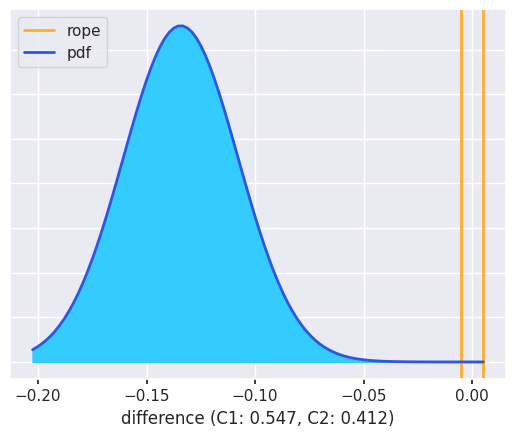

In [434]:
# Obtenemos las correlaciones en batches
spearman_corr_A, spearman_corr_B = get_correlations_in_batches(classifier_A, classifier_B)

# Calculamos las probabilidades usando baycomp
probabilities, fig = baycomp.two_on_single(spearman_corr_A, spearman_corr_B, rope=0.005, runs=10, plot=True)
print(f"Probabilidad de que el clasificador A sea mejor que el clasificador B: {probabilities[0]}")
print(f"Probabilidad de que el clasificador A sea igual al clasificador B: {probabilities[1]}")
print(f"Probabilidad de que el clasificador B sea mejor que el clasificador A: {probabilities[2]}")

plt.show()

In [435]:
# Agregar resultados a global_results
global_results = pd.concat([
    global_results,
    pd.DataFrame([["cifar100", "gradient_scorer", "synflow_ones_estimator", 15000, probabilities[0], probabilities[1], probabilities[2]]] , columns=global_results.columns)
])

### Gradient scorer vs Gradient cosine

In [436]:
# Cargamos los clasificadores gradient scorer y gradient cosine para 15 mil redes en cifar100
classifier_A_name = "./results/results_gradient_scorer_cifar100_15000.csv"
classifier_B_name = "./results/results_gradiente_cosine_estimator_cifar100_15000.csv"

classifier_A = pd.read_csv(classifier_A_name)
classifier_B = pd.read_csv(classifier_B_name)

In [437]:
# Mostramos sus correlaciones
show_pearson_and_spearman_correlations(classifier_A, classifier_B)

Correlación de Pearson para classifier_A_name: 0.7805991663174051
Correlación de Spearman para classifier_A_name: 0.5932615764274851

Correlación de Pearson para classifier_B_name: 0.4990280966388385
Correlación de Spearman para classifier_B_name: 0.4435285696678814


Probabilidad de que el clasificador A sea mejor que el clasificador B: 0.9999994012741786
Probabilidad de que el clasificador A sea igual al clasificador B: 5.005674512670311e-07
Probabilidad de que el clasificador B sea mejor que el clasificador A: 9.815837009874429e-08


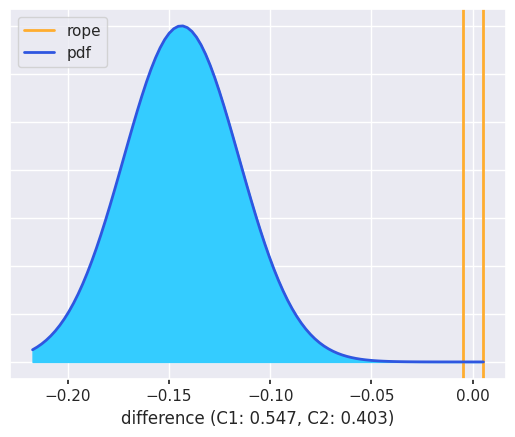

In [438]:
# Obtenemos las correlaciones en batches
spearman_corr_A, spearman_corr_B = get_correlations_in_batches(classifier_A, classifier_B)

# Calculamos las probabilidades usando baycomp
probabilities, fig = baycomp.two_on_single(spearman_corr_A, spearman_corr_B, rope=0.005, runs=10, plot=True)
print(f"Probabilidad de que el clasificador A sea mejor que el clasificador B: {probabilities[0]}")
print(f"Probabilidad de que el clasificador A sea igual al clasificador B: {probabilities[1]}")
print(f"Probabilidad de que el clasificador B sea mejor que el clasificador A: {probabilities[2]}")

plt.show()

In [439]:
# Agregar resultados a global_results
global_results = pd.concat([
    global_results,
    pd.DataFrame([["cifar100", "gradient_scorer", "gradient_cosine_estimator", 15000, probabilities[0], probabilities[1], probabilities[2]]] , columns=global_results.columns)
])

### Synflow vs Gradient cosine

In [440]:
# Cargamos los clasificadores synflow y gradient cosine para 15 mil redes en cifar10
classifier_A_name = "./results/results_synflow_ones_estimator_cifar100_15000.csv"
classifier_B_name = "./results/results_gradiente_cosine_estimator_cifar100_15000.csv"

classifier_A = pd.read_csv(classifier_A_name)
classifier_B = pd.read_csv(classifier_B_name)

In [441]:
# Mostramos sus correlaciones
show_pearson_and_spearman_correlations(classifier_A, classifier_B)

Correlación de Pearson para classifier_A_name: 0.5719247341198609
Correlación de Spearman para classifier_A_name: 0.4531253238458501

Correlación de Pearson para classifier_B_name: 0.4990280966388385
Correlación de Spearman para classifier_B_name: 0.4435285696678814


Probabilidad de que el clasificador A sea mejor que el clasificador B: 0.6519328943048501
Probabilidad de que el clasificador A sea igual al clasificador B: 0.24163456286949536
Probabilidad de que el clasificador B sea mejor que el clasificador A: 0.10643254282565451


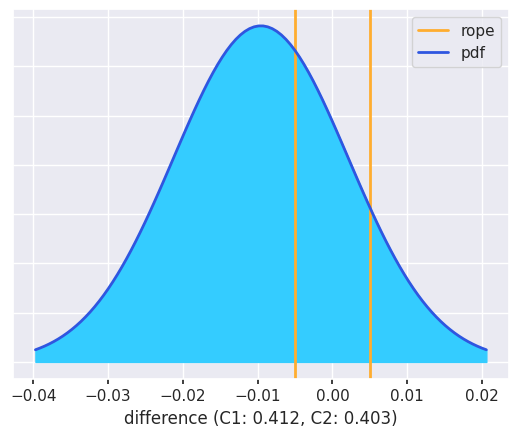

In [442]:
# Obtenemos las correlaciones en batches
spearman_corr_A, spearman_corr_B = get_correlations_in_batches(classifier_A, classifier_B)

# Calculamos las probabilidades usando baycomp
probabilities, fig = baycomp.two_on_single(spearman_corr_A, spearman_corr_B, rope=0.005, runs=10, plot=True)
print(f"Probabilidad de que el clasificador A sea mejor que el clasificador B: {probabilities[0]}")
print(f"Probabilidad de que el clasificador A sea igual al clasificador B: {probabilities[1]}")
print(f"Probabilidad de que el clasificador B sea mejor que el clasificador A: {probabilities[2]}")

plt.show()

In [443]:
# Agregar resultados a global_results
global_results = pd.concat([
    global_results,
    pd.DataFrame([["cifar100", "synflow_ones_estimator", "gradient_cosine_estimator", 15000, probabilities[0], probabilities[1], probabilities[2]]] , columns=global_results.columns)
])

# Conclusión

Gradient Scorer muestra una notable superioridad sobre el resto de los algoritmos. Aunque SynFlow y Gradient Cosine obtienen resultados más equilibrados, SynFlow demuestra ser ligeramente superior en ambos casos, con tasas de igualdad cercanas al 50%. En contraste, Gradient Scorer destaca por su mejor desempeño general, con tasas muy bajas de igualdad, lo que permite concluir que Gradient Scorer presenta un rendimiento superior.

In [444]:
global_results

,Dataset,Algorithm A,Algorithm B,size_dataset,P(A>B),P(A=B),P(B>A)
0,cifar10,gradient_scorer,synflow_ones_estimator,15000,0.875516,6.313158e-02,6.135279e-02
0,cifar10,gradient_scorer,gradient_cosine_estimator,15000,0.880314,5.935583e-02,6.033006e-02
0,cifar10,synflow_ones_estimator,gradient_cosine_estimator,15000,0.398577,3.111155e-01,2.903072e-01
0,cifar100,gradient_scorer,synflow_ones_estimator,15000,0.999999,4.940500e-07,8.171507e-08
0,cifar100,gradient_scorer,gradient_cosine_estimator,15000,0.999999,5.005675e-07,9.815837e-08
0,cifar100,synflow_ones_estimator,gradient_cosine_estimator,15000,0.651933,2.416346e-01,1.064325e-01
